In [1]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
import math
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import mad_std
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
#
# Pandas
#
import pandas as pd
#
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Remove Warnings
#
import warnings
warnings.filterwarnings('ignore')
#
# Font params
#
font = {'weight': 'regular', 
        'size': 16}
font2 = {'weight': 'regular', 
        'size': 12}

In [2]:
# grab list of files and SN data

# prefix = "/home/maykerchen.1/Desktop/"
# prefix = "/Users/mayker.1/Desktop/"
prefix = "/Users/nessmayker/Desktop/"

fileList = prefix + "SNeJWST/Data/filelist1566.txt"
fileNames = np.genfromtxt(fileList, dtype=str, unpack=True, usecols=(0))
fileNames = [prefix + "JWSTLargeFiles/ngc1566_v0p6alpha/" + x for x in fileNames]

# SN information
SNname = "SN2021aefx"
SNtype = "Ia"
SNra   = 64.9725
SNdec  = -54.94808055555555
dist_to_1566 = 17.69
z = 0.00502

# filter information
imgs = ["nircam_clear-f200w", "nircam_clear-f300m", "nircam_clear-f335m",
        "nircam_clear-f360m","miri_f770w", "miri_f1000w", "miri_f1130w", "miri_f2100w"]
titles = ["F200W", "F300M", "F335M",
        "F360M", "F770W", "F1000W", "F1130W", "F2100W"]
delta_lambda = [0.461,0.318,0.347,0.372,2.2,2.0,0.7,5.0] #[microns]
lambda_0 = [1.990,2.996,3.365,3.621,7.7,10.0,11.3,21.0] #[microns]

#filter PSF FWHMs
#https://jwst-docs.stsci.edu/jwst-near-infrared-camera
#https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-performance/miri-point-spread-functions
psf_fwhm_asecs = [0.064,0.097, 0.109,0.118,0.269,0.328,0.375,0.674] 

#WebPSF filenames
psfFiles = ["NIRCam_PSF_filter_F200W.fits","NIRCam_PSF_filter_F300M.fits",
            "NIRCam_PSF_filter_F335M.fits","NIRCam_PSF_filter_F360M.fits",
            "MIRI_PSF_filter_F770W.fits","MIRI_PSF_filter_F1000W.fits",
            "MIRI_PSF_filter_F1130W.fits","MIRI_PSF_filter_F2100W.fits"]
psfFiles = ["../Data/JWST_PSF/" + x for x in psfFiles]


In [3]:
# Functions

# Function to CHECK IF RAS AND DECS ARE IN AN IMAGE
def check_in_image(SNras, SNdecs, SNnames, SNtypes, GalaxyImg):
    
#     for i in range(len(SNnames)):
#         if SNnames[i] == "SN1983V":
#             SNtypes[i] = "Ic"
    
    hdulist = fits.open(GalaxyImg)
    map = hdulist[1].data
    wcs = WCS(hdulist[1].header, naxis=0)
    #print(wcs._naxis)
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist[1].header['NAXIS1']
    naxis2 = hdulist[1].header['NAXIS2']
    is_in_x = (pix_x >= 0) & (pix_x <= naxis1-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis2-1)
        
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]  
    
    c_delt = hdulist[1].header['CDELT1']
    dist = 17.69 * 10**6 # Handcoded just for 1566 for now until I know how to find this in file
    theta1kpc = np.arctan((1000./dist)*(180./np.pi)) # theta for 1kpc scalebar
    theta100pc = np.arctan((100./dist)*(180./np.pi)) # theta for 1kpc scalebar

    return (name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2, c_delt, dist, theta1kpc, theta100pc)


In [4]:
# set up plots & wcs information - saves all the information used in the plots.
plots, wcss, hdus, names, types, ras, decs, xs, ys, maps, nax1s, nax2s, cds, dist = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
cdas,scalebars, cutoutsbs =[],[],[]

for i in range(len(fileNames)):
    if os.path.isfile(fileNames[i]):
        ns, ts, rs, ds, xcs, ycs, ms, n1s, n2s, cd, d, tkpc, tpc = check_in_image(SNra, SNdec, SNname, SNtype, 
                                                                                  fileNames[i])
        names.append(ns)
        types.append(ts)
        ras.append(rs)
        decs.append(ds)
        xs.append(xcs)
        ys.append(ycs)
        maps.append(ms)
        nax1s.append(n1s)
        nax2s.append(n2s)
        cds.append(cd)
        dist.append(d)
        JWST_hdu = fits.open(fileNames[i])
        hdus.append(JWST_hdu)
        JWST_map = JWST_hdu[1].data
        plots.append(JWST_map)
        wcss.append(WCS(JWST_hdu[1].header, naxis=2))
        cdelt_as = cd * 3600
        cdas.append(cdelt_as)
        t_as     = tkpc  * 3600
        t_as_cutout = tpc *  3600
        t_as = np.round(t_as,1)
        t_as_cutout =  np.round(t_as_cutout,1)
        sb = ScaleBar(cdelt_as,"''",dimension="angle",label="1 kpc",length_fraction=None,fixed_value=t_as,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font, scale_loc = None)
        scalebars.append(sb)
        sb_co = ScaleBar(cdelt_as,"''",dimension="angle",label="100 pc",length_fraction=None,fixed_value=t_as_cutout,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font2, scale_loc = None)
        cutoutsbs.append(sb_co)

        

In [5]:
# set up plot specifics

titleFS = 20 #fontsize
legendFS = 14

markerShapes = ["o", "s", "p", "D", "X", "H", "v"]
markerSizes  = [210,150,310,150,330,310,350]
markerEdges  = [410,350,610,350,630,610,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

# set up legend labels
legendLabels = []

for i in range(len(names)):
    legendlabel = []
        
    if len(names[i]) > 1:
        for k in range(len(names[i])):
            if types[i][k] == 'unclassified' or types[i][k] == 'Unclassified':
                typelabel = names[i][k] + ' '  + types[i][k]
            else:
                typelabel = names[i][k] + ' Type '  + types[i][k]
            legendlabel.append(typelabel)
    else:
        if types[i][0] == 'unclassified' or types[i][0] == 'Unclassified':
            legendlabel.append(names[i][0] + ' '  + types[i][0]) 
        else:        
            legendlabel.append(names[i][0] + ' Type '  + types[i][0])
    legendLabels.append(legendlabel)


<Figure size 640x480 with 0 Axes>

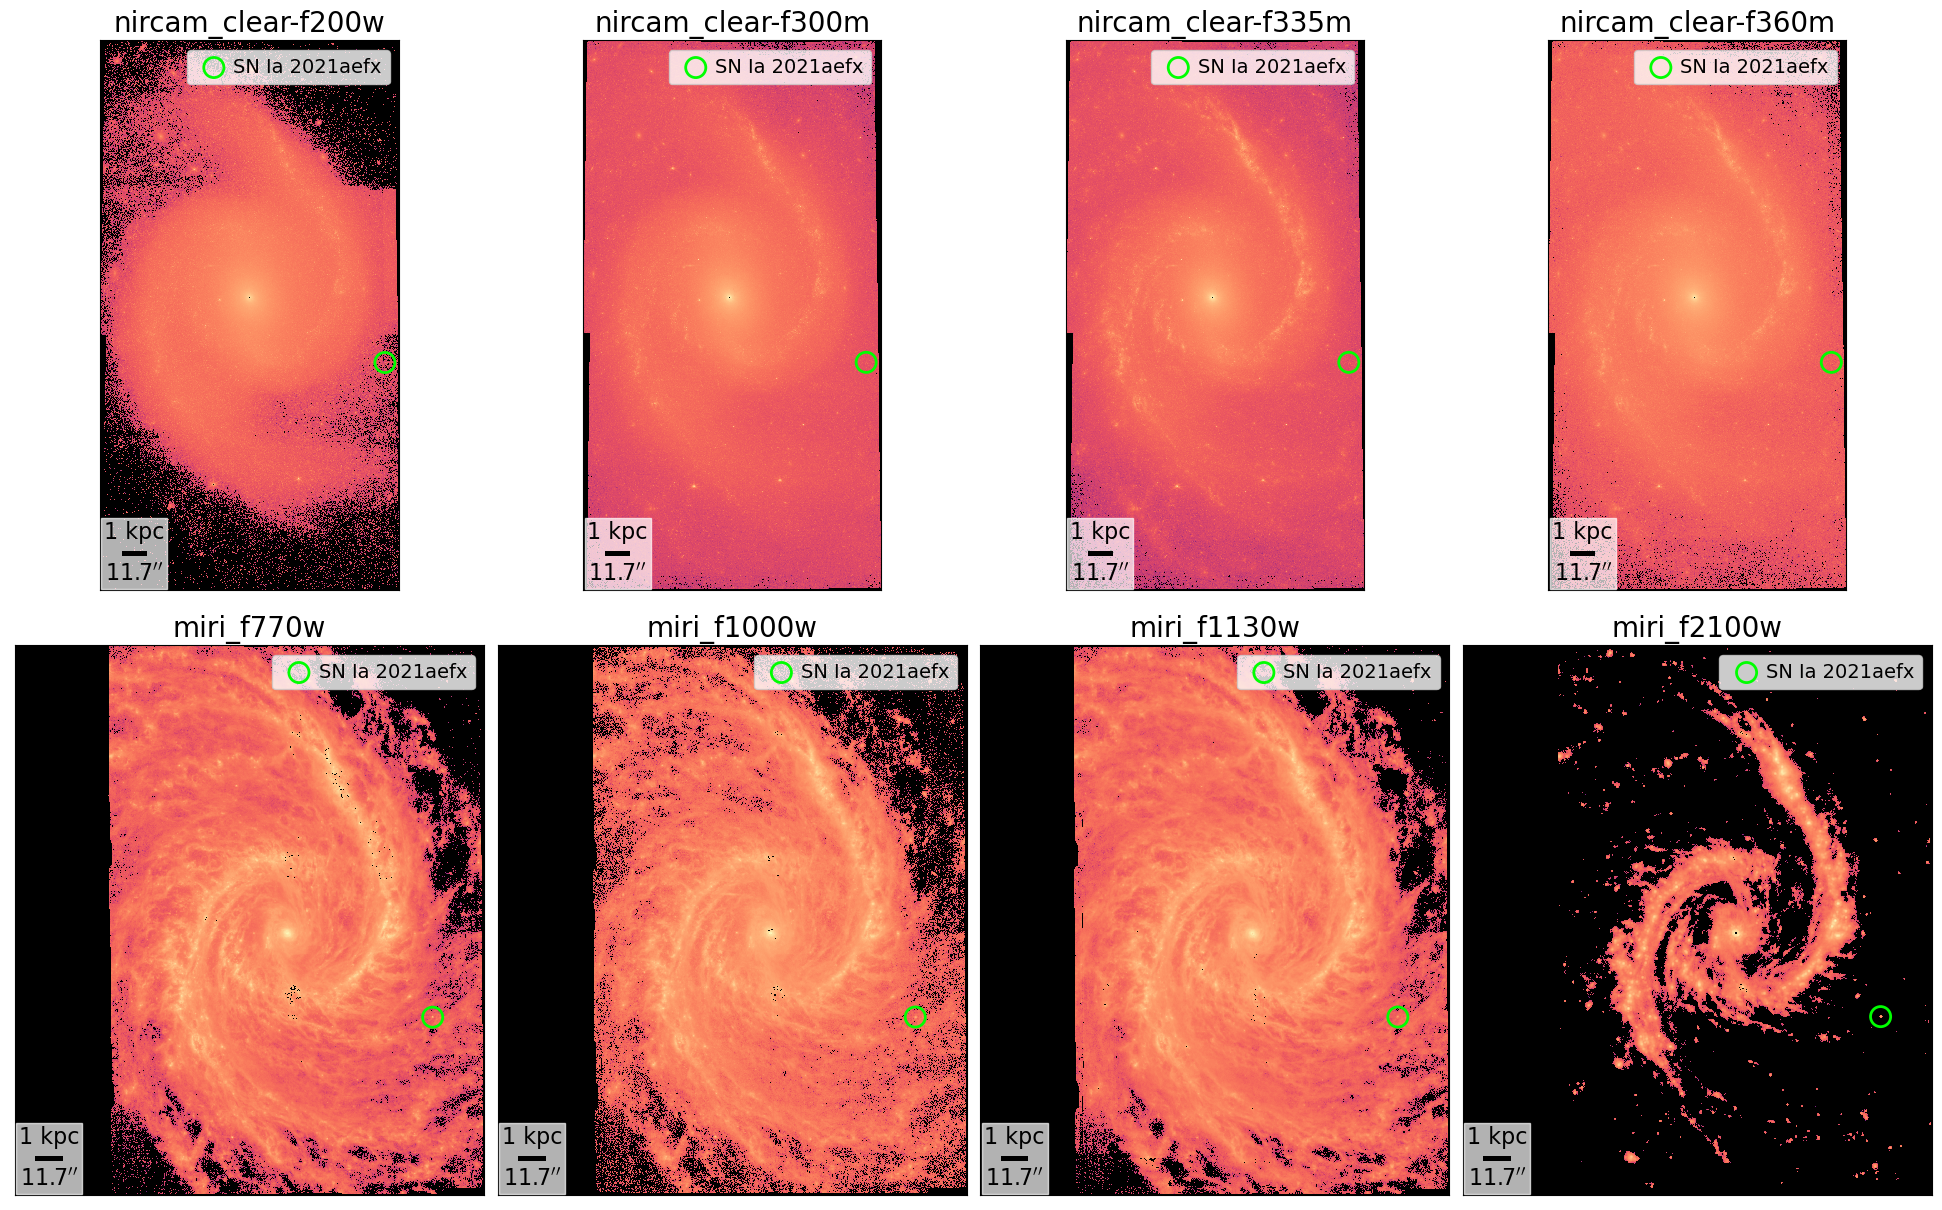

In [6]:
# make multipanel plot  
plt.clf()
i,j,m=0,0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(30, 15))

for plot in plots:
    
    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    
    logplot = np.log10(plot)
    pos = axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest")
#                     vmin=np.percentile(plot,1), vmax=np.percentile(plot,99))
    axs[i][j].set_title(imgs[m], fontsize=titleFS)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
      
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], facecolor = "none", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="lime", linewidth=2, label = "SN Ia 2021aefx", zorder = 2)
    axs[i][j].legend(loc="best", fontsize=legendFS, handletextpad=0.007)
    axs[i][j].add_artist(scalebars[m])

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m+=1

plt.subplots_adjust(wspace=-0.45, hspace=0.1)
plt.show()
fig.savefig("../Figures/NGC1566allPanels.png", dpi=300)
plt.close()


<Figure size 640x480 with 0 Axes>

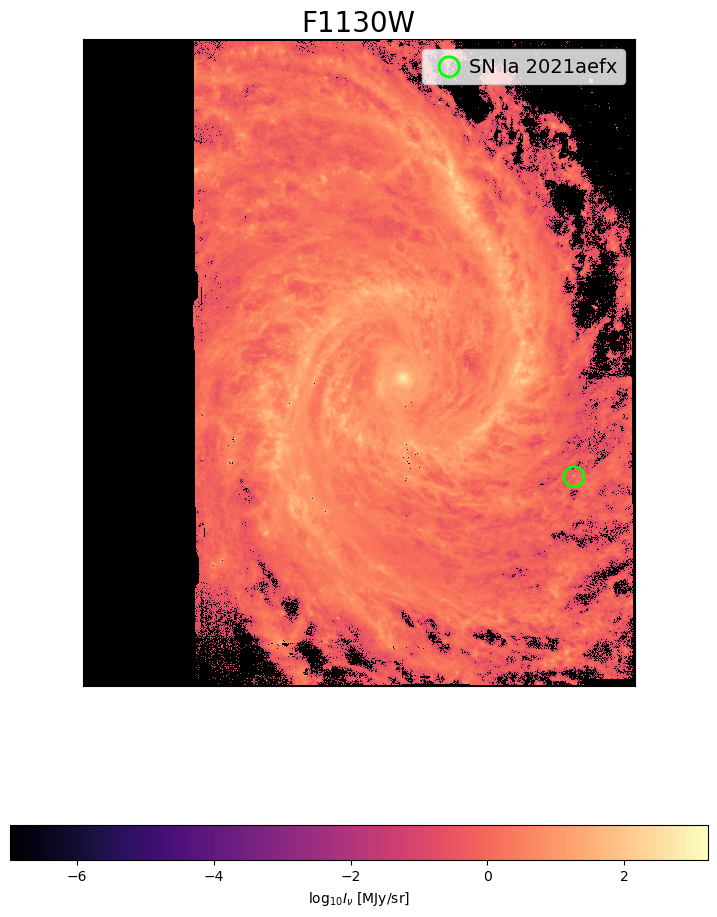

In [7]:
# make F1130W plot with colorbar
plt.clf()
m=6
plot = plots[m]
ra,dec = ras[m],decs[m]
wcs=wcss[m]

fig, ax  = plt.subplots(figsize=(9,12))
xArr, yArr = wcs.wcs_world2pix(ra,dec,0)
logplot = np.log10(plot)
pos = ax.imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest")

ax.set_title("F1130W", fontsize=titleFS)
ax.set_xticks([])
ax.set_yticks([])
      
ax.scatter(xArr, yArr, facecolor = "none", marker = markerShapes[0], s = markerSizes[0], 
                      edgecolor="lime", linewidth=2, label = "SN Ia 2021aefx", zorder = 2)
ax.legend(loc="best", fontsize=14, handletextpad=0.007)

cbar = plt.colorbar(pos,orientation="horizontal",label=r'$\log_{10} I_{\nu}$ [MJy/sr]') # ticks=[]
cbar.ax.set_ylabel(r'$\log_{10} I_{\nu}$ [MJy/sr]', rotation=0)

plt.show()
fig.savefig("../Figures/F1130W.png", dpi=300)
plt.close()


In [8]:
# Get angular sizes of interest (used to size cutouts)

def findAngSize(sphere, dist):
    """ Finds the angular size in decimal degrees when given the 
        size of the sphere in pc and the
        distance to the galaxy in Mpc
    """
    
    angSizeRad = np.arctan(sphere/(dist*10**6))
    angSize = angSizeRad * (180/np.pi)

    return(angSize)

sphereSizes = [200,1000]
angSizes = []

ang200 = findAngSize(sphereSizes[0], dist_to_1566) #angular size of 200pc
ang1000 = findAngSize(sphereSizes[1], dist_to_1566)

angSizes.append([ang200, ang1000])



In [9]:
#subplot padding changes

lft = 0.1
btm = 0.1
rht = 0.99
tp  = 0.7
wsp = 0.45
hsp = 0.5
pd  = 0.5
wpd = 3.0
hpd = 0.4

# plotting code
def makeZooms(rows, columns, images, SNra, SNdec, SNname, SNtype, size=(10,5), log=True):
    m,n,p =0,0,0 # plot counters for total number, rows, columns
    PLOTS_PER_ROW = columns
    numPanels = int(rows*columns)
    figname = SNname
    figname, axs = plt.subplots(math.ceil(numPanels/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=size)

    for j in range(len(images)): # counter to count wavelengths

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        if log == True:
            data = np.log10(data)
        wcs=wcss[j]

        halfBox = angSizes[0][1] # 1000 pc in decimal degrees
        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        #size = u.Quantity((20,20), u.arcsec) #size is size of box in arcsec 
        size = u.Quantity((halfBox,halfBox), u.degree) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(data, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        y1 = yval * 0.2
        x1 = xval * 0.1

        titleStr = images[j]

        # make plot
        if rows == 1:
            
            axs[n].set_title(titleStr, fontsize=14)    
            axs[n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                          interpolation = "nearest", zorder = 0, vmin=np.percentile(cutout.data,1), 
                          vmax=np.percentile(cutout.data,99))
            axs[n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
            axs[n].set_xlabel("")
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].tick_params(axis = "both", direction = "in", length = 0)
            axs[n].axis('off')
            axs[n].axhline(y1,0.1,0.2, color="white")
            axs[n].text(x1, yval * 0.4, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')

            n+=1
            p+=1
            
        else:
            axs[m][n].set_title(titleStr, fontsize=14)    
            axs[m][n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                             interpolation = "nearest", zorder = 0,  vmin=np.percentile(cutout.data,1), 
                          vmax=np.percentile(cutout.data,99))
            axs[m][n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
            axs[m][n].set_xlabel("")
            axs[m][n].set_xticks([])
            axs[m][n].set_yticks([])
            axs[m][n].tick_params(axis = "both", direction = "in", length = 0)
            axs[m][n].axis('off')
            axs[m][n].axhline(y1,0.1,0.2, color="white")
            axs[m][n].text(x1, yval * 0.4, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')

            n+=1
            if n%PLOTS_PER_ROW==0:
                m+=1
                n=0
            p +=1
        figname.suptitle(SNname + ": " + SNtype, fontsize=20)
        plt.subplots_adjust(left = lft, bottom = btm, right = rht, top = tp, wspace = wsp, hspace = hsp)
    plt.tight_layout(pad=pd, w_pad=wpd, h_pad=hpd)
#     figname.savefig("../Figures/NGC1566_Zooms_" + SNname + ".pdf", dpi=300)
    plt.show()


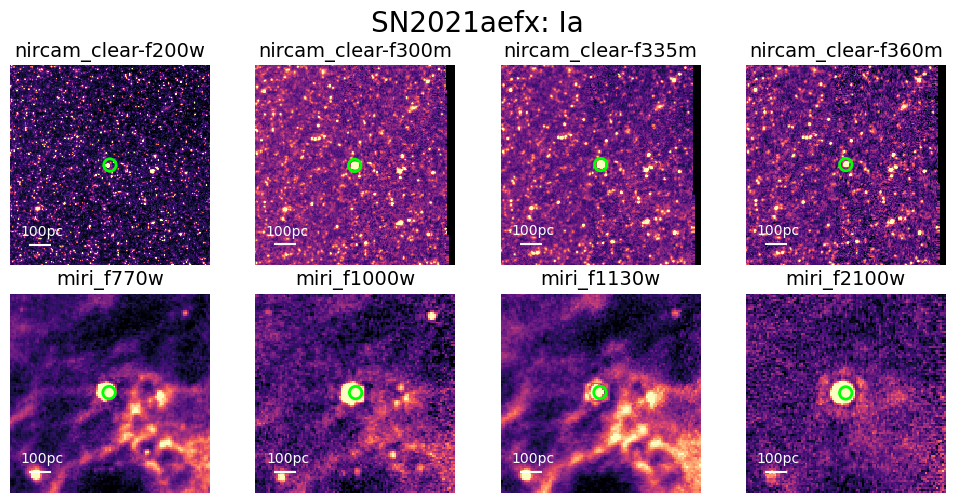

In [10]:
# Zoom plot
makeZooms(2,4, imgs, SNra, SNdec, SNname, SNtype, log=False)          #SN2021aefx


In [11]:
# Set up photutils and apertures within cutout.

def getPhot(m,coords1,coords2,rad,rin, rout, img,cdelt,psf,errRangeVals):
    # read in coords of central pixel (chosen by hand if astrometry is off)
    xval,yval = coords1[0],coords1[1]

    # Statistical noise of whole map is found by generating 100 random apertures in signalless region 
    # read in max and min coord ranges (selected by hand in ds9)
    Xmin, Ymin, Xmax, Ymax = errRangeVals[0],errRangeVals[1],errRangeVals[2],errRangeVals[3]
    
    # randomly assign 100 apertures within the range using same radius as measurement
    xs = [random.randint(Xmin, Xmax) for p in range(0,100)]
    ys = [random.randint(Ymin, Ymax) for p in range(0,100)]
    errPos = np.transpose((xs, ys)) 
    errAps = CircularAperture(errPos, r=rad)

    # set up photutils table
    err_table = aperture_photometry(plots[m], errAps) 
    errApsSums = err_table['aperture_sum']
    statErr = mad_std(errApsSums)    # measure scatter of apertures mad_Std numpy    
        
    # Set cutout size based on filter being used
    if m <= 3:
        halfBox = angSizes[0][0] # 200 pc in decimal degrees for NIRCam
        
    else:
        halfBox = angSizes[0][1] # 1000 pc in decimal degrees for MIRI
    
    data = plots[m]
    # data = np.log10(data)
    wcs=wcss[m]

    #cutout2D needs skycoord position to carry units
    ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
    position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
    size = u.Quantity((halfBox,halfBox), u.degree) #size is size of box in arcsec 
    # make 2D cutout, will assign a new wcs to cutout to keep track of coords
    cutout = Cutout2D(data, position, size, wcs) 

    # This shows the actual x and y values at the ra and dec. 
    # if astrometry is good xval should be equal to xvalAct.
    xvalAct, yvalAct = cutout.wcs.wcs_world2pix(ra,dec, 0)
#     print(xvalAct,yvalAct)

    # get ra and dec of aperture center pixels used for the aperture
    ra,dec=cutout.wcs.wcs_pix2world(xval,yval, 0)
    ra, dec = Angle(ra * u.degree), Angle(dec * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad   

    #make new cutout so that image is centered on aperture (if the astrometry is bad)
    position = SkyCoord(ra, dec) #position is center, use ra & dec of SN location
    cutout = Cutout2D(data, position, size, wcs) 
    
    #get the new central coords 
    xval,yval = coords2[0],coords2[1]
    
    #convert apertures to decimal degrees
    angRad = rad * cdelt 
#     print("radius=",angRad,"decimal degrees")
    rad_asec = angRad * 3600.
    print("radius=",rad_asec,"arcseconds")
#     print("ra,dec =", ra,dec)
    
    # Photutils Photometry
    #Get apertures set up
    positions = np.transpose((xval, yval)) 
    apertures = CircularAperture(positions, r=rad)
    annulus_apertures = CircularAnnulus(positions, r_in=rin, r_out=rout)

    # make table
    phot_table = aperture_photometry(cutout.data, apertures)  

    #Subtract background
    aperstats = ApertureStats(cutout.data, annulus_apertures)
    bkg_mean = aperstats.mean
    aperture_area = apertures.area_overlap(cutout.data)
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg

    #add to table
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    
    
    #Find aperture correction
    psf_hdu = fits.open(psf) #open psf file
    psf_map = psf_hdu[0].data
#     total_flux = np.sum(psf_map) 
#     print("PSF Total Flux:",total_flux)
    pix_scale = psf_hdu[0].header['PIXELSCL'] #find pixel scale 
    naxis1 = psf_hdu[0].header['NAXIS1']/2.0
    naxis2 = psf_hdu[0].header['NAXIS2']/2.0

    peak = np.argmax(psf_map) # find peak of psf
#     print("Peak index:", peak)
    pixels = rad_asec / pix_scale # convert aperture radius used to their pixel scale
    peak_position = np.transpose((naxis1, naxis2)) 
    PSFaperture = CircularAperture(peak_position, r=pixels) # place aperture on peak and measure flux out to radius
    acorr_table = aperture_photometry(psf_map, PSFaperture) 
    acorr = acorr_table["aperture_sum"] # determine aperture correction
    new_phot = phot_bkgsub / acorr
    phot_table['acorr'] = acorr #add to table
    phot_table['Flux_corr'] = new_phot
    
    
    #format and print table
    for col in phot_table.colnames:  
        phot_table[col].info.format = '%.8g'  # for consistent table output
    print(phot_table) 
 
    # use this new wcs when converting to pixels to add additional details to plot
    # xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
    y1 = yval * 0.2
    x1 = xval * 0.1

    plt.imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                  interpolation = "nearest", zorder = 0, vmin=np.percentile(cutout.data,1), 
               vmax=np.percentile(cutout.data,99))
    apertures.plot(color='lime',zorder=2, lw=2)
    annulus_apertures.plot(color='cyan',zorder=2,lw=2)

    #set up the scalebars
    if m <= 3:
        plt.axhline(y1,0.1,0.2, color="white",lw=2)
        plt.text(xval*0.16, yval * 0.15, "20pc", color="white", horizontalalignment = 'left', verticalalignment = 'top',fontsize=14)
    else:
        plt.axhline(yval * 1.8,0.1,0.2, color="white",lw=2)
        plt.text(xval*0.14, yval * 1.75, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top', fontsize=14)
        
    plt.axis('off')
    plt.title(titles[m], fontsize = 20)
    plt.savefig(imgs[m],transparent = True, dpi=300)
    plt.show()
    print(xval,yval,rad,ra,dec,phot_table["Flux_corr"][0],img, angRad,acorr, statErr)
    return(xval,yval,rad,ra,dec,phot_table["Flux_corr"][0],img, angRad,acorr, statErr)


radius= 0.128 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr    Flux_corr
      pix     pix                ...                                         
--- ------- ------- ------------ ... ------------------- ---------- ---------
  1  37.347   37.76    722.63151 ...           706.89904 0.78077168 905.38509


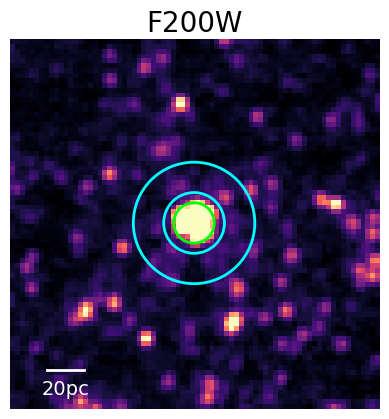

37.347 37.76 4.163166195430663 64d58m21.26481164s -54d56m53.11410515s 905.385087517079 nircam_clear-f200w 3.555555555555556e-05    aperture_sum   
------------------
0.7807716805711171 55.11470112350018
radius= 0.194 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr    Flux_corr
      pix     pix                ...                                         
--- ------- ------- ------------ ... ------------------- ---------- ---------
  1  17.604  17.515    131.02731 ...           121.48076 0.79801165 152.22931


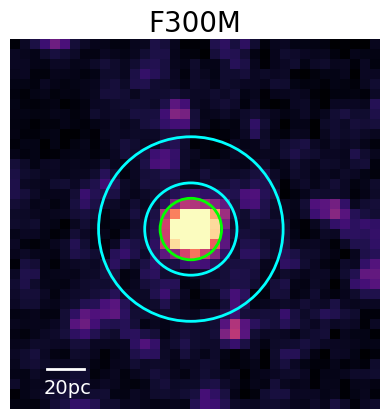

17.604 17.515 3.079429515446461 64d58m20.95693715s -54d56m53.09350882s 152.22930906080074 nircam_clear-f300m 5.388888888888889e-05    aperture_sum   
------------------
0.7980116475886995 1.2119170928485063
radius= 0.21799999999999997 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr    Flux_corr
      pix     pix                ...                                         
--- ------- ------- ------------ ... ------------------- ---------- ---------
  1  18.016  18.303     176.7596 ...           165.25539 0.79942935 206.71669


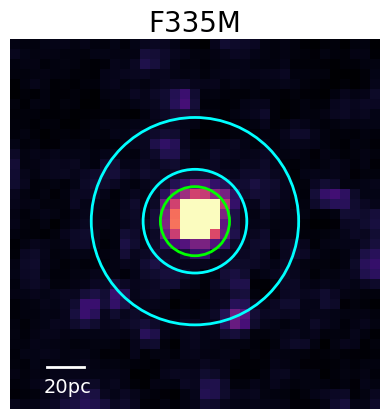

18.016 18.303 3.4603265315723806 64d58m21.00244596s -54d56m53.09266454s 206.71669412788034 nircam_clear-f335m 6.055555555555555e-05    aperture_sum   
------------------
0.7994293499862059 1.621835257841189
radius= 0.23599999999999996 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr    Flux_corr
      pix     pix                ...                                         
--- ------- ------- ------------ ... ------------------- ---------- ---------
  1  18.016  18.303    51.967091 ...            41.04556 0.80248931 51.147797


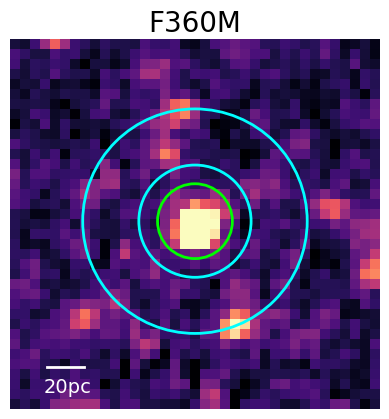

18.016 18.303 3.7460408108892658 64d58m20.9530212s -54d56m53.06447937s 51.14779735017336 nircam_clear-f360m 6.555555555555554e-05    aperture_sum   
------------------
0.8024893053396196 1.4815032889595796
radius= 0.538 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr   Flux_corr
      pix     pix                ...                                        
--- ------- ------- ------------ ... ------------------- --------- ---------
  1  51.647  52.362     818.8033 ...           775.49846 0.8351389  928.5862


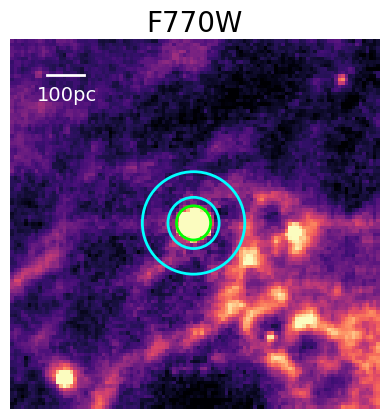

51.647 52.362 4.850392762279098 64d58m21.35459576s -54d56m53.03641706s 928.5862014373066 miri_f770w 0.00014944444444444445    aperture_sum   
------------------
0.8351389012874779 3.2679234724680075
radius= 0.6559999999999999 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr    Flux_corr
      pix     pix                ...                                         
--- ------- ------- ------------ ... ------------------- ---------- ---------
  1  52.283  52.344    525.78983 ...            492.6395 0.82187002 599.41291


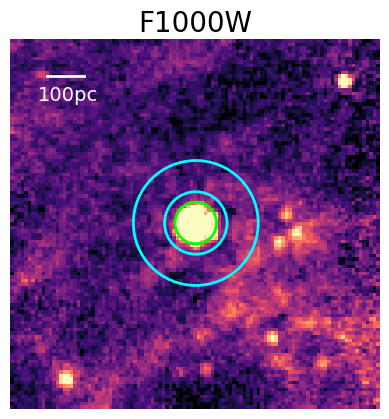

52.283 52.344 5.914252808662972 64d58m21.42541175s -54d56m53.17757858s 599.4129129920459 miri_f1000w 0.0001822222222222222    aperture_sum   
------------------
0.8218700190076074 4.147205402433589
radius= 0.75 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr   Flux_corr
      pix     pix                ...                                        
--- ------- ------- ------------ ... ------------------- --------- ---------
  1   51.75  52.439    648.92245 ...           516.91268 0.8239303 627.37429


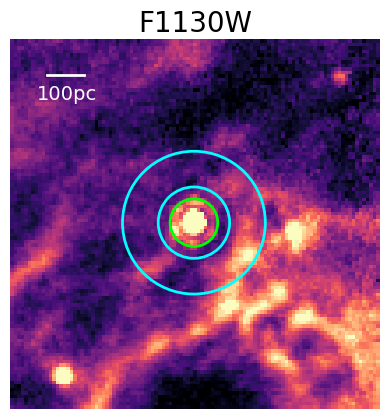

51.75 52.439 6.761952252613692 64d58m21.38645379s -54d56m53.09310216s 627.3742895872973 miri_f1130w 0.00020833333333333335    aperture_sum  
-----------------
0.823930297279378 9.485585213414279
radius= 1.348 arcseconds
 id xcenter ycenter aperture_sum ... aperture_sum_bkgsub   acorr    Flux_corr
      pix     pix                ...                                         
--- ------- ------- ------------ ... ------------------- ---------- ---------
  1  51.971  52.165    538.18293 ...           1246.4145 0.81861887 1522.5822


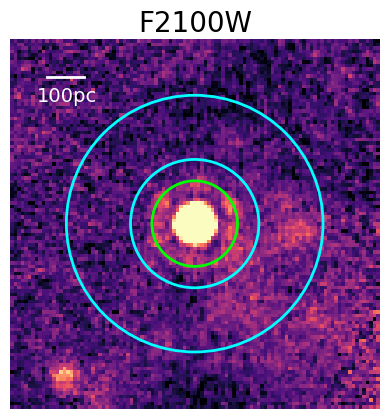

51.971 52.165 12.153470815718252 64d58m21.37950402s -54d56m53.06279697s 1522.5821828228077 miri_f2100w 0.00037444444444444444    aperture_sum   
------------------
0.8186188653306741 31.186164791308098


In [12]:
# For this code, I ran the aperture photometry first with the ra and dec of the SN. I then printed and adjusted new 
#coordinates until I found the central pixel accounting for the imperfect astrometry. 

#set min and max ranges by eye to use for random aperture range for statistical uncertainty measurement
minMax = [[1640,3350,2180,3832],[1640,3550,2180,4032],[1640,3550,2180,4032],[1640,3550,2180,4032],[1496,1853,1782,2081],[1496,1853,1782,2081],[1496,1853,1782,2081],[1496,1853,1782,2081]]

#select coords by eye for central pixels of SN when astrometry is off
#Cords1: true x and y values for ra and dec location of SN
cords1 = [[32.5,36.5],[18,17.5],[18.25,18.25],[18.4,18.75],[49.8,52.8],[50.1,51.5],[49.75,52.362244],[50,52.362244]]
#Cords2: used x and y values when astrometry is off
cords2 = [[37.347, 37.760],[17.604, 17.515],[18.016, 18.303],[18.016, 18.303],[51.647, 52.362],[52.283, 52.344],[51.75, 52.439],[51.971, 52.165]]

#set up aperture radii
radii = [2*x/y for x,y in zip(psf_fwhm_asecs,cdas)] # choose 2 * FWHM for aperture radii
r_in = [x*1.5 for x in radii] #inner radius for background subtraction
r_out = [x*3 for x in radii] #outer radius for background subtraction

xvals,yvals,rads,ras,decs,fcs,imgName, angRads,acorrs,statErrs = [],[],[],[],[],[],[],[],[],[]
for i in range(len(imgs)):
    xval,yval,rad,ra,dec,fc,img,angRad,acorr,statErr = getPhot(i,cords1[i],cords2[i],radii[i],r_in[i],r_out[i],imgs[i],cds[i],psfFiles[i],minMax[i])
    xvals.append(xval)
    yvals.append(yval)
    rads.append(rad)
    ras.append(ra)
    decs.append(dec)
    fcs.append(fc)
    imgName.append(img)
    angRads.append(angRad * 3600)
    acorrs.append(acorr)
    statErrs.append(statErr)
    
statErrs = [(x/y) for x,y in zip(statErrs, acorrs)]# aperture correct stats errs    



In [13]:
# convert flux density [MJy/str] to flux in mJy
def find_mJy(fcs,cdelt,radius): #fc is flux corrected [MJy/str]
    flux = []
    for i in range(len(cdelt)):
        sr_per_pix = cdelt[i]**2 * (np.pi/180.)**2 # convert the cdelt in decimal degrees to steradian 
        flux.append(fcs[i] * 10**9 * sr_per_pix) # convert from Mega to milli (* 10^9)
    return(flux)
#flux in Jy
NessFlux = find_mJy(fcs,cds,rads)
statErrs = find_mJy(statErrs,cds,rads)


In [14]:
# convert flux (mJy) to solar Luminosity
# Nu and Del_Nu are x 10^-13 s^-1
# Nu_Lnu, Delta_Lnu are x 10^-5 Lsun

def find_Lum(flux_mJy,lambda_0,delta_lambda,d_Mpc):

    m_per_Mpc = 3.086 * 10**22     # [m / Mpc]
    ergs_per_Lsun = 3.826 * 10**33 # [erg s-1 / L_sun]
    ergs_per_Jy = 10**(-19)        # [erg⋅s−1⋅m−2⋅Hz−1 / Jy]
    c = 299792458                  # [m/s]
    m_per_micron = 10**(-6)        # [m / micron]

    Nu, Del_Nu, Nu_Lnu, Delta_Lnu = [],[],[],[]
    
    for i in range(len(flux_mJy)):
        flux_Jy   = flux_mJy[i] * 10**(-3) # [Jy]
        flux_ergs = flux_Jy * ergs_per_Jy   # [erg⋅s−1⋅m−2⋅Hz−1]
        L_nu = 4 * np.pi * (d_Mpc)**2 * (m_per_Mpc)**2 * flux_ergs * (1+z)**3 # [erg]
        nu_0 = c/(lambda_0[i] * m_per_micron) # [1/s]
        
        delta_nu = np.abs(c / ((lambda_0[i] + delta_lambda[i]/2.) * m_per_micron) - 
                          c / ((lambda_0[i] - delta_lambda[i]/2.) * m_per_micron))   # [1/s]
                
        Nu_L_nu = L_nu * nu_0 # [ergs /s]        
        Delta_nu_L_nu = L_nu * delta_nu # [ergs /s] 
        Nu.append(nu_0 * 10**-13)
        Del_Nu.append(delta_nu * 10**-13)
        Nu_Lnu.append(Nu_L_nu / ergs_per_Lsun * 10**-5)
        Delta_Lnu.append(Delta_nu_L_nu / ergs_per_Lsun * 10**(-5))
   
    return(Nu, Del_Nu,Nu_Lnu, Delta_Lnu) 



In [15]:
# convert flux to solar luminosity
Nu, Del_Nu, NuLnu, DeltanuLnu = find_Lum(NessFlux, lambda_0,delta_lambda, dist_to_1566)
Nu_Fnu = [x*y*10**13 for x,y in zip(Nu,NessFlux)] #Nu_Fnu in [mJy/s]


In [23]:
fluxTable = Table({"Image":titles,                   
                   "Lambda":lambda_0,
                   "Delta_lambda":delta_lambda,
                   "Aperature Radius [arcsec]": angRads,
                   "Aperature Correction": acorrs,
                   "Flux [mJy]": NessFlux,
                   "Statistical Uncertainty [mJy]":statErrs,
                   "Nu L_nu [10^5 L_sun]": NuLnu,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu,
                   "Nu [10^13 s^-1]": Nu,
                   "Delta_nu [10^13 s^-1]": Del_Nu})

fluxTable


<Table length=8>
Image   Lambda Delta_lambda ...  Nu [10^13 s^-1]   Delta_nu [10^13 s^-1]
 str6  float64   float64    ...      float64              float64       
------ ------- ------------ ... ------------------ ---------------------
 F200W    1.99        0.461 ... 15.064947638190956     3.537378889048217
 F300M   2.996        0.318 ... 10.006423831775702    1.0650969070584704
 F335M   3.365        0.347 ...  8.909136939078753     0.921162243862086
 F360M   3.621        0.372 ...  8.279272521402929    0.8528134175266672
 F770W     7.7          2.2 ... 3.8934085454545464    1.1355774924242434
F1000W    10.0          2.0 ... 2.9979245800000003    0.6056413292929289
F1130W    11.3          0.7 ... 2.6530306017699115   0.16450484692417774
F2100W    21.0          5.0 ... 1.4275831333333335   0.34478718573893047